# Importation des packages 

In [0]:
import numpy as np
import pandas as pd
import re
import keras

from matplotlib import pyplot

from keras.preprocessing import sequence
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, concatenate, Embedding, Input, Flatten
from keras.layers.embeddings import Embedding
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

#Charger le dataset Textuelle

In [0]:
dataframe = pd.read_csv("/content/drive/My Drive/mbti.csv", header=0)
dataset = dataframe.values
Y = dataset[:,0]
Ycat = np.unique(Y)
X = pd.DataFrame(data= dataset[:,1])

##Preprocess

In [0]:
def preprocess(x):
  x = str(x)
  x = x.lower()
  x = re.sub(r'\|\|\|', ' ', x)
  x = re.sub(r'https?://(w{3})?(\.?\w+)+[\w?=\.\-/]+', '', x)
  x = re.sub(r'[^a-z\s]', '', x)                  # get rid of noise
  x = re.sub(r'\s{2,}', ' ', x)
  x = re.sub(r'^\s*', '', x)
  #x = [w for w in x.split() if w not in set(stopwords)]  # remove stopwords
  return x

In [0]:
Xprepro = X.T.apply(lambda x: preprocess(x.values))

In [6]:
Xsplit = Xprepro.apply(lambda x: re.sub("[^\w]", " ",  x).split())
X_uniq = len(np.unique(np.hstack(Xsplit)))

145930


Training Data: 
(8675,)
(8675,)
Catégories: 
['ENFJ' 'ENFP' 'ENTJ' 'ENTP' 'ESFJ' 'ESFP' 'ESTJ' 'ESTP' 'INFJ' 'INFP'
 'INTJ' 'INTP' 'ISFJ' 'ISFP' 'ISTJ' 'ISTP']
Number of words: 
145930
Review length: 
Mean 1253.29 words (314.346058)


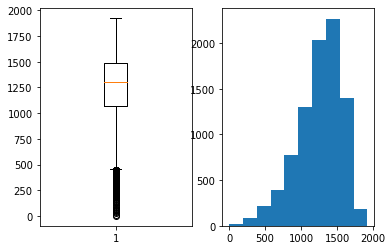

In [30]:
print("Training Data: ")
print(Xprepro.shape)
print(Y.shape)
print("Catégories: ")
print(Ycat)
print("Number of words: ")
print(X_uniq)
print("Review length: ")
result = [len(x) for x in Xsplit[1:]]
#result = [*map(len, Xprepro)] #map n'est pas une liste dany py3 -> [*  ] le transforme en list
print("Mean %.2f words (%f)" % (np.mean(list(result)), np.std(result)))
pyplot.subplot(121)
pyplot.boxplot(result)
pyplot.subplot(122)
pyplot.hist(result)
pyplot.show()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(Xprepro, Y, test_size=0.33, random_state=42)

In [0]:
max_words = 1500

In [75]:
X_train = sequence.pad_sequences(X_train, maxlen = max_words)
X_test = sequence.pad_sequences(X_test, maxlen = max_words)

ValueError: ignored

In [76]:
model = Sequential()
model.add(Embedding(8675, 32, input_length=max_words))
model.add(Flatten())
model.add(Dense(250,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 32)          277600    
_________________________________________________________________
flatten_1 (Flatten)          (None, 48000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               12000250  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 251       
Total params: 12,278,101
Trainable params: 12,278,101
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=12000, verbose=1)
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

ValueError: ignored

### TF-IDF, Vec

In [0]:
vectorizer = TfidfVectorizer(max_features=300, stop_words='english', analyzer='word')
vectorizer = vectorizer.fit(X_train)

df_train = vectorizer.transform(X_train)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

maxlen = 50

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_train = pad_sequences(sequences_train, maxlen=maxlen)

In [0]:
df_train

<5812x300 sparse matrix of type '<class 'numpy.float64'>'
	with 686919 stored elements in Compressed Sparse Row format>

#Models

##Dense relu-relu-sig

In [0]:
model = Sequential()
model.add(Dense(4, input_dim=1, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, kernel_initializer='normal', activation='relu')
model.add(Dense(12, kernel_initializer='normal', activation='sigmoid')
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

TypeError: ignored

In [0]:
vocab_size = len(tokenizer.word_index) + 1
embedding_size = 300

input_tfidf = Input(shape=(300,))
input_text = Input(shape=(maxlen,))

embedding = Embedding(vocab_size, embedding_size, input_length=maxlen)(input_text)

mean_embedding = keras.layers.Lambda(lambda x: keras.backend.mean(x, axis=1))(embedding)

concatenated = concatenate([input_tfidf, mean_embedding])

dense1 = Dense(256, activation='relu')(concatenated)
dense2 = Dense(32, activation='relu')(dense1)
dense3 = Dense(8, activation='sigmoid')(dense2)

model = Model(inputs=[input_tfidf, input_text], outputs=dense3)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [0]:
concatenated

<tf.Tensor 'concatenate_1/concat:0' shape=(None, 600) dtype=float32>

In [0]:
model.fit(x=X_train, y=y_train, verbose=2, epochs=100, batch_size=32)

ValueError: ignored

In [0]:
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
dummy_y = np_utils.to_categorical(encoded_Y)

In [0]:
estimator = KerasClassifier(build_fn = model, nb_epoch = 200, batch_size = 6, verbose = 0)
kfold = KFold(n_splits = 10, shuffle= True, random_state = 42)
results = cross_val_score(estimator, Xprepro, dummy_y, cv = kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([['enfp and intj moments sportscenter not top ten plays pranks what has been the most lifechanging experience in your life on repeat for most of today may the perc experience immerse you the la...

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model e

Accuracy: nan% (nan%)
